In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 20:01:27.624685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 20:01:28.133405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [3]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [4]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [5]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)


Unique values and their frequency:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


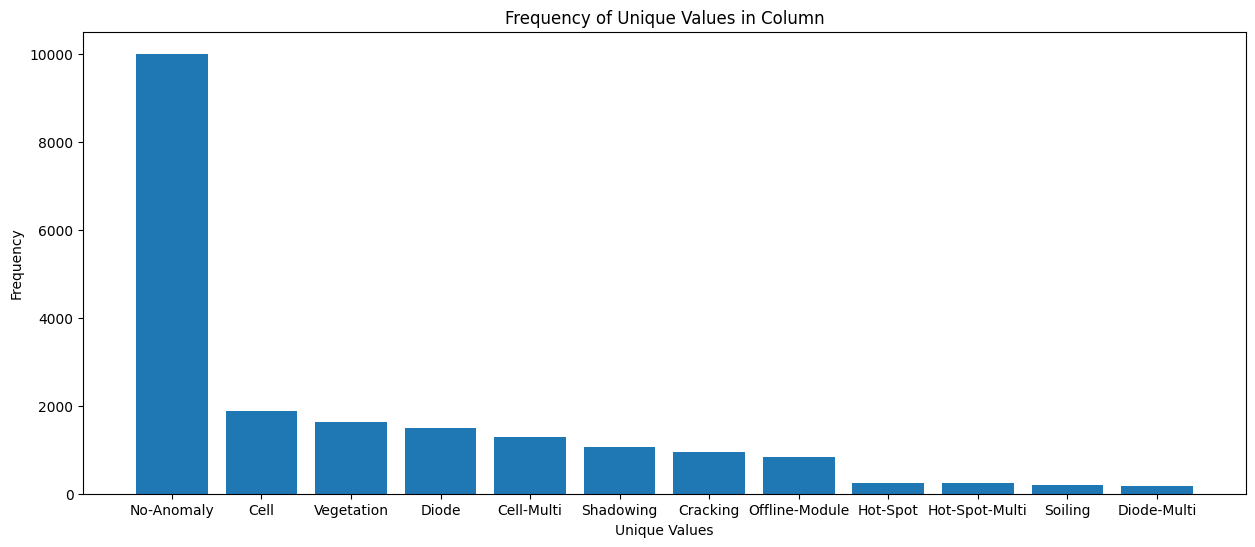

In [6]:
# Get unique values and their frequency
unique_values = DataSolarModules['anomaly_class'].value_counts()
print("\nUnique values and their frequency:")
print(unique_values)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()

In [7]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [8]:
# Sample specified amount of images per class for training set
def sample_training_set(dataframe, samples):
    train_indices = []
    for cls, num_samples in enumerate(samples):
        class_indices = dataframe[dataframe['class_code'] == cls].index[num_images_per_class:]
        sampled_indices = class_indices[:num_samples].tolist()
        train_indices.extend(sampled_indices)
    return train_indices

samples = [802,150,1000,1000,1000,1000,224,915, 219, 179, 1000, 7000]
train_indices = sample_training_set(DataSolarModules, samples)
data_train = np.array(train_indices)


Unique values and their frequency in the training set:
anomaly_class
No-Anomaly        7000
Diode             1000
Shadowing         1000
Cell-Multi        1000
Cell              1000
Vegetation        1000
Cracking           900
Offline-Module     787
Hot-Spot           209
Hot-Spot-Multi     206
Soiling            164
Diode-Multi        135
Name: count, dtype: int64

Unique values and their frequency in the testing set:
anomaly_class
Offline-Module    40
Diode-Multi       40
Diode             40
Shadowing         40
Cell-Multi        40
Cell              40
Hot-Spot          40
Cracking          40
Hot-Spot-Multi    40
Soiling           40
Vegetation        40
No-Anomaly        40
Name: count, dtype: int64


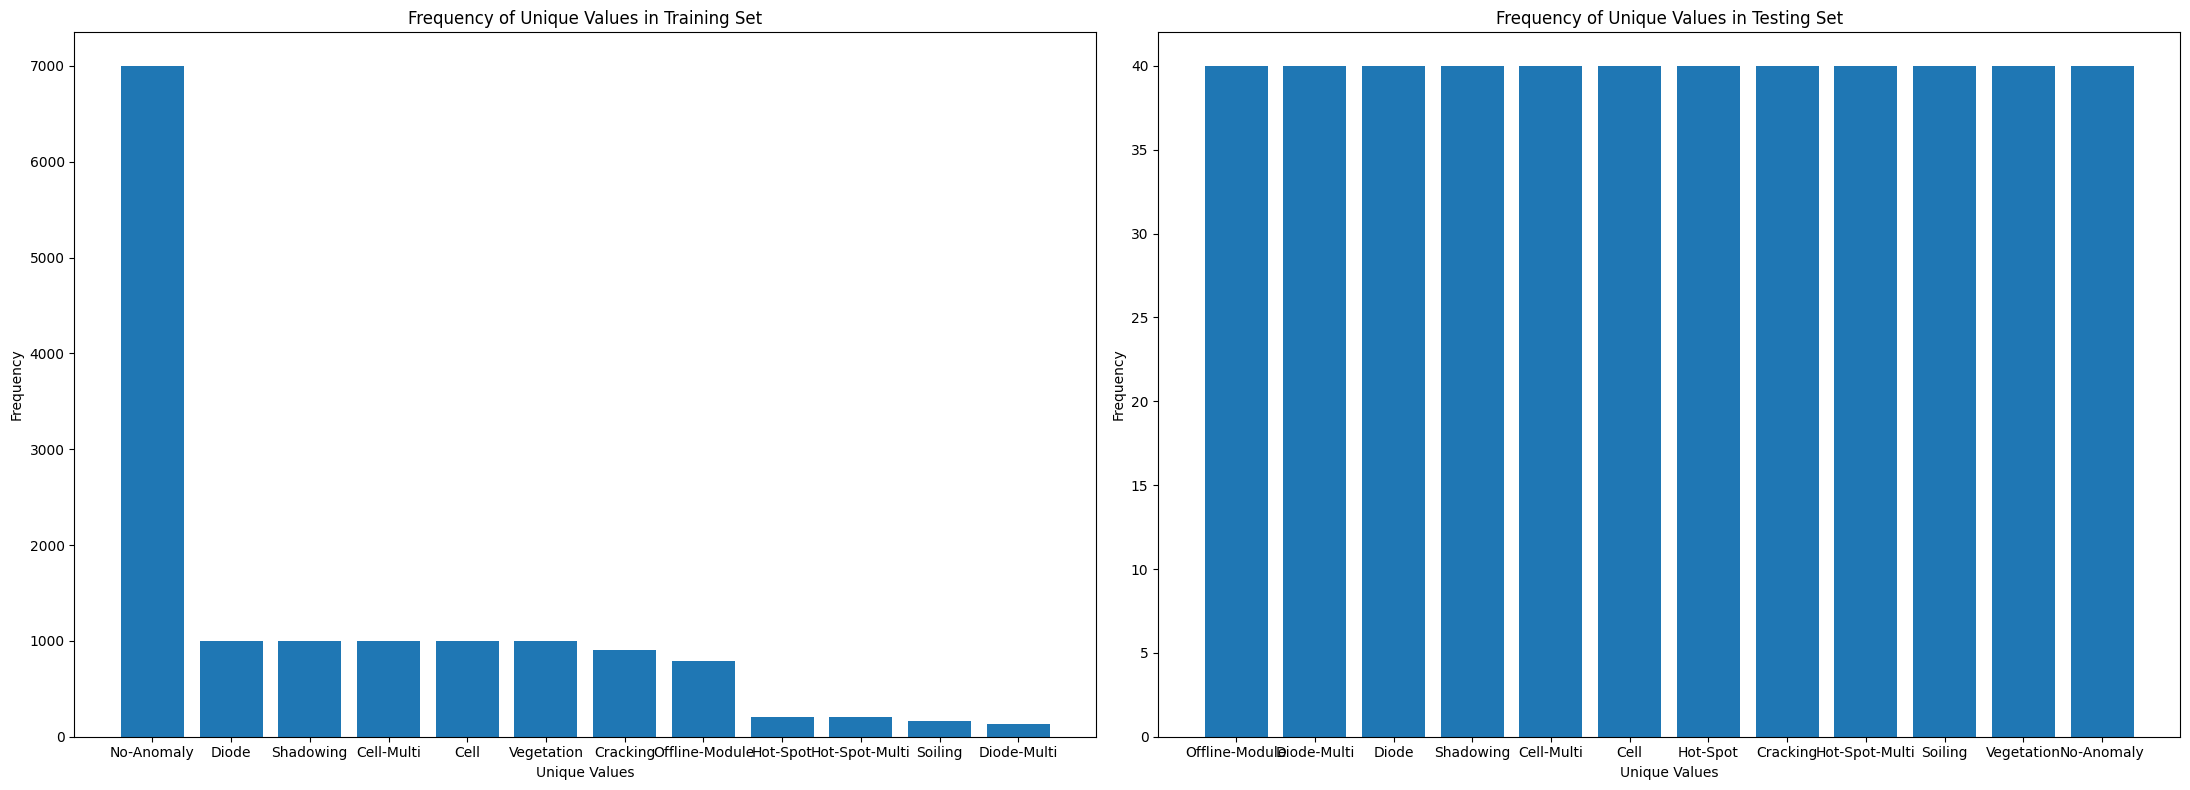

In [9]:
# Calculate unique values and their frequency in the training set
train_class_counts = DataSolarModules.iloc[data_train]['anomaly_class'].value_counts()
print("\nUnique values and their frequency in the training set:")
print(train_class_counts)

# Calculate unique values and their frequency in the testing set
test_class_counts = DataSolarModules.iloc[data_test]['anomaly_class'].value_counts()
print("\nUnique values and their frequency in the testing set:")
print(test_class_counts)

# Plot the bar chart for the training set
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.index, train_class_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Training Set')

# Plot the bar chart for the testing set
plt.subplot(1, 2, 2)
plt.bar(test_class_counts.index, test_class_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Testing Set')

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 20:01:32.215535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:01:32.254415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 20:01:32.254670: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(images)))


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [12]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716638493.781049  113097 service.cc:145] XLA service 0x73f264002230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716638493.781071  113097 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 20:01:33.815621: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 20:01:33.995978: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


111/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2788 - loss: 2.2308

I0000 00:00:1716638498.142050  113097 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2889 - loss: 2.2003

I0000 00:00:1716638502.139056  113100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_4', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716638502.939979  113318 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716638503.220415  113308 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716638503.286375  113325 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716638505.089540  113419 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 284 bytes spill stores, 284 bytes spill loads

I0000 00:00:1716638505.237146  1

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.2890 - loss: 2.2000 - val_accuracy: 0.2882 - val_loss: 2.1074
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3118 - loss: 2.0913 - val_accuracy: 0.2882 - val_loss: 2.0893
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3131 - loss: 2.0631 - val_accuracy: 0.3432 - val_loss: 1.9558
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3656 - loss: 1.9266 - val_accuracy: 0.3953 - val_loss: 1.7975
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3966 - loss: 1.8069 - val_accuracy: 0.4740 - val_loss: 1.6261
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4701 - loss: 1.6292 - val_accuracy: 0.5010 - val_loss: 1.5061
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4946 - loss: 1.5623 - val_accuracy: 0.5115 - val_loss: 1.5141
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5127 - loss: 1.4981 - val_accuracy: 0.5069 - va

I0000 00:00:1716638513.691197  114932 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716638514.036308  114927 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716638514.309460  114924 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads



Score for fold 1: loss of 1.0681663751602173; compile_metrics of 65.7642662525177%
Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6940 - loss: 0.9397 - val_accuracy: 0.7212 - val_loss: 0.7971
Epoch 2/25
 69/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6914 - loss: 0.8912

I0000 00:00:1716638519.241494  113096 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_4', 4 bytes spill stores, 4 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6910 - loss: 0.8990 - val_accuracy: 0.7008 - val_loss: 0.8800
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6953 - loss: 0.9061 - val_accuracy: 0.7138 - val_loss: 0.8410
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7055 - loss: 0.8618 - val_accuracy: 0.6992 - val_loss: 0.8645
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7215 - loss: 0.8155 - val_accuracy: 0.7133 - val_loss: 0.8216
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7183 - loss: 0.8192 - val_accuracy: 0.7117 - val_loss: 0.8430
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7246 - loss: 0.7798 - val_accuracy: 0.7250 - val_loss: 0.8264
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7321 - loss: 0.7741 - val_accuracy: 0.6846 - val_loss: 0.8996
Epoch 9/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7463 - loss: 0.7491 - val_accuracy: 0.7067 - val_

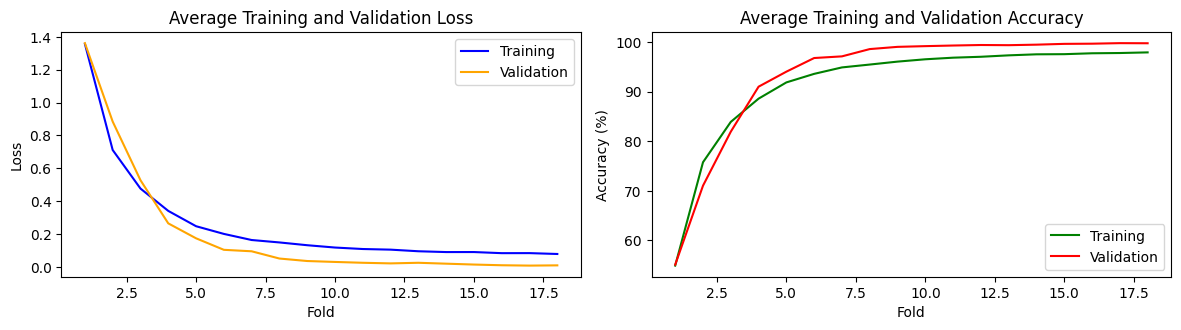

In [13]:
plt.figure(figsize=(12, 6))

# Plotting average training and validation losses
plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue', label='Training')
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange', label='Validation')
plt.title('Average Training and Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

# Plotting average training and validation accuracies
plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green', label='Training')
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red', label='Validation')
plt.title('Average Training and Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 1.0000 - loss: 0.0024   
Test loss: 0.002649166388437152
Test accuracy: 1.0


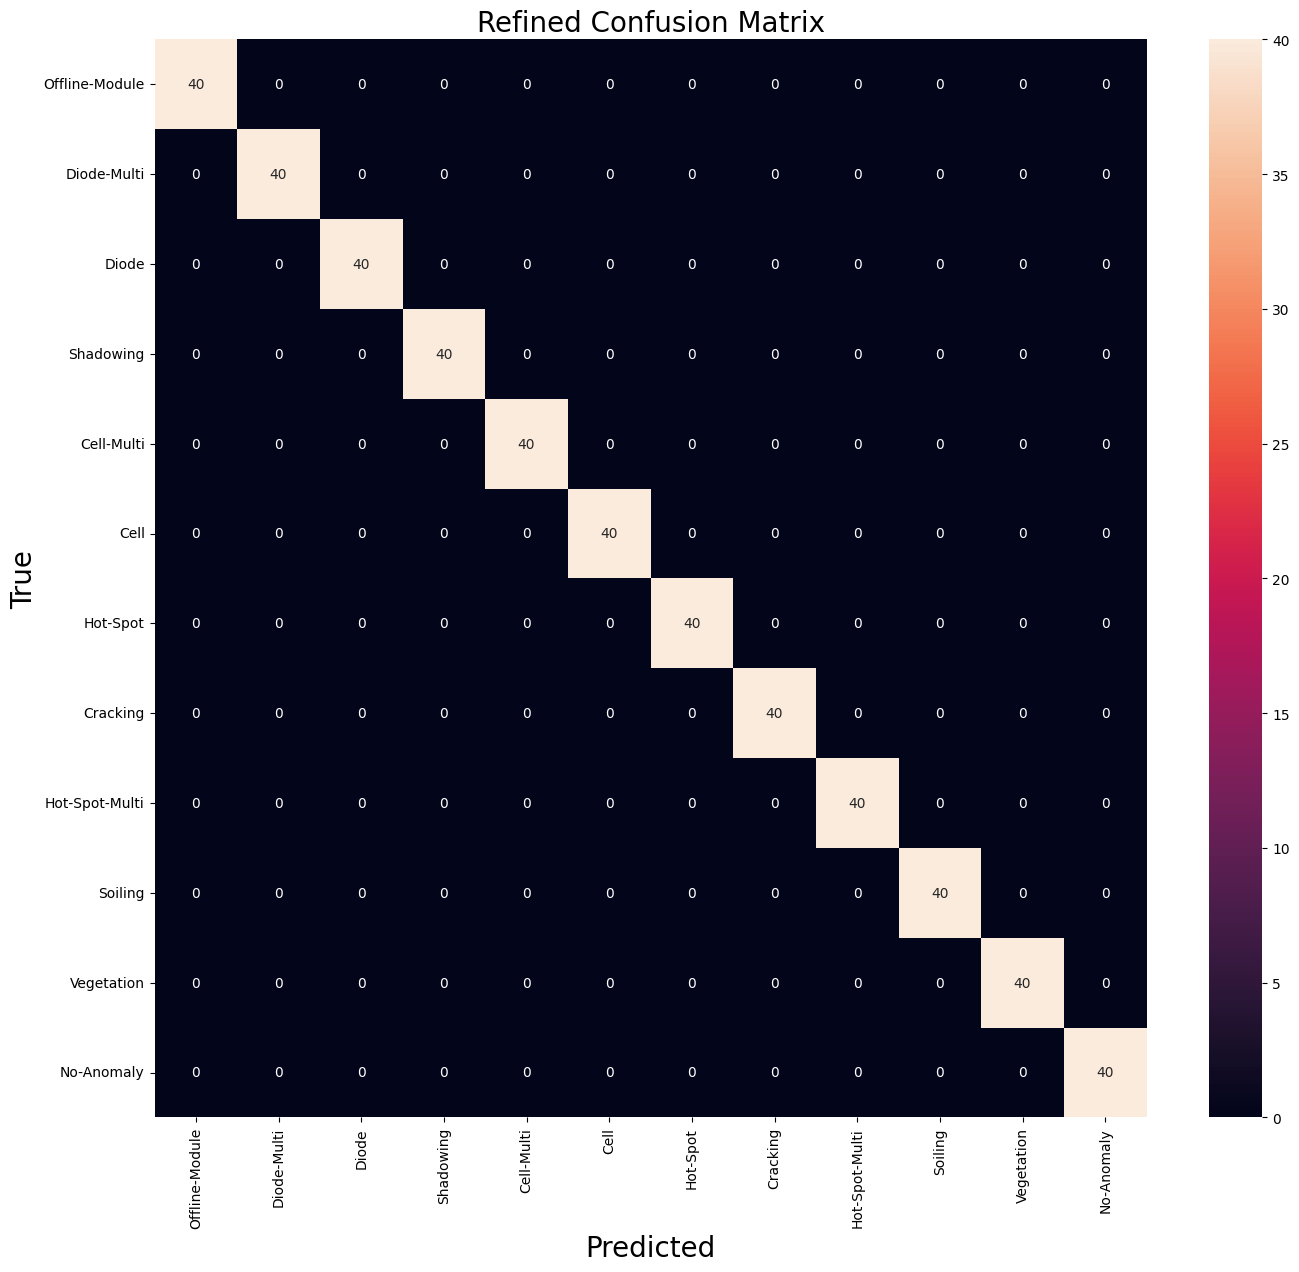

In [15]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [16]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [17]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics  Values
0           Accuracy     1.0
1  Average Precision     1.0
2     Average Recall     1.0
3   Average F1 Score     1.0


In [18]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module        1.0     1.0       1.0
1      Diode-Multi        1.0     1.0       1.0
2            Diode        1.0     1.0       1.0
3        Shadowing        1.0     1.0       1.0
4       Cell-Multi        1.0     1.0       1.0
5             Cell        1.0     1.0       1.0
6         Hot-Spot        1.0     1.0       1.0
7         Cracking        1.0     1.0       1.0
8   Hot-Spot-Multi        1.0     1.0       1.0
9          Soiling        1.0     1.0       1.0
10      Vegetation        1.0     1.0       1.0
11      No-Anomaly        1.0     1.0       1.0
